# Notebook 3: Pattern Analysis & Modeling Prep

![Over-Complicating Things](../media/over_complicating_things.jpg)

**Phases 6-7:** Pattern Analysis & Advanced Visualization, Modeling Preparation

**Dataset:** NYC Taxi Trip Dataset (continuing from Notebook 2)

**Focus:** Deep analysis of patterns, advanced visualizations, and preparing data for predictive modeling.

---

**Where we are:** We've cleaned our data (Notebook 1) and created features (Notebook 2). Now we need to understand patterns deeply and prepare data for modeling.

**What we'll accomplish:**

- Identify trends over time
- Discover seasonal patterns (daily, weekly cycles)
- Analyze correlations between variables
- Split data temporally for modeling
- Select and prepare features

**Why this matters:**

- Pattern analysis guides feature selection and model interpretation
- Temporal splits prevent data leakage (critical for time series!)
- Proper preparation ensures model quality

**The big picture:**

- **Notebook 1:** Made data clean ✓
- **Notebook 2:** Made data useful ✓
- **Notebook 3 (this one):** Make data ready for modeling
- **Notebook 4:** Build and evaluate models

---

## Phase 6: Pattern Analysis & Advanced Visualization

**What we're about to do:** Before we build models, we need to understand our data deeply. Pattern analysis helps us identify which features are most important, understand relationships between variables, and spot anomalies.

**What we'll discover:**

- Temporal patterns (hourly, daily, weekly cycles)
- Relationships between variables (correlations)
- Trends over time
- Seasonal effects

**How this informs modeling:** The patterns we find here will guide feature selection and help us interpret model results.

### Learning Objectives

- Create advanced multi-panel visualizations
- Identify trends and seasonal patterns
- Perform statistical analysis
- Visualize relationships across multiple dimensions

### Step 1: Load Processed Data

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Load processed data from Notebook 2
df = pd.read_csv('../output/02_processed_taxi_data.csv')
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])

# Limit to 2023
df = df[df['pickup_datetime'].dt.year == 2023].reset_index(drop=True)

# Filter to valid rows if exclude column exists (should already be filtered in NB2)
if 'exclude' in df.columns:
    df = df[~df['exclude']].drop(columns=['exclude', 'exclude_reason'], errors='ignore')

display(Markdown("### 📂 Data Loaded"))
display(pd.DataFrame({
    'Metric': ['Total trips', 'Date range'],
    'Value': [
        f"{len(df):,}",
        f"{df['pickup_datetime'].min()} to {df['pickup_datetime'].max()}"
    ]
}))

### 📂 Data Loaded

,Metric,Value
0,Total trips,"2,879,085"
1,Date range,2023-01-01 00:00:05 to 2023-01-31 23:59:59


### Step 2: Trends Analysis Over Time

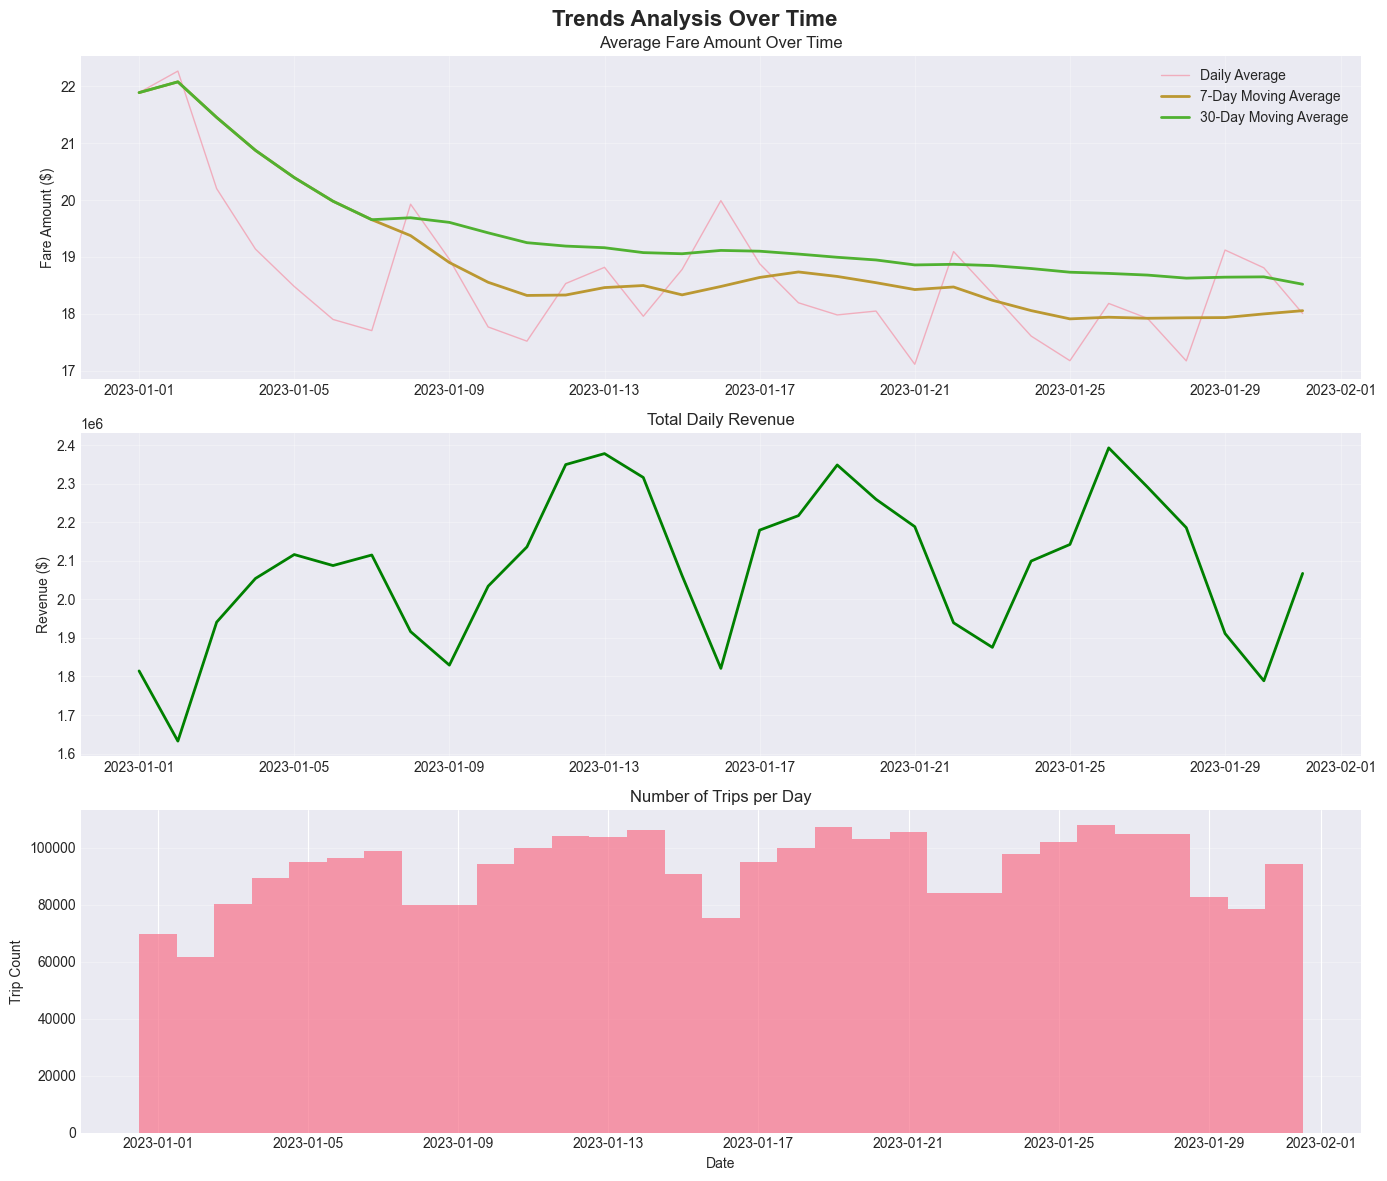

In [2]:
# Set datetime index for time-based operations
df_ts = df.set_index('pickup_datetime').sort_index()

# Resample to daily for trend analysis
daily = df_ts.resample('d').agg({
    'fare_amount': 'mean',
    'total_amount': 'sum',
    'trip_distance': 'count'  # Count trips
}).rename(columns={'trip_distance': 'trip_count'})

# Calculate moving averages for trend detection
daily['fare_7d_ma'] = daily['fare_amount'].rolling(window=7, min_periods=1).mean()
daily['fare_30d_ma'] = daily['fare_amount'].rolling(window=30, min_periods=1).mean()

# Visualize trends
fig, axes = plt.subplots(3, 1, figsize=(14, 12))
fig.suptitle('Trends Analysis Over Time', fontsize=16, fontweight='bold')

# Average fare over time
axes[0].plot(daily.index, daily['fare_amount'], alpha=0.5, label='Daily Average', linewidth=1)
axes[0].plot(daily.index, daily['fare_7d_ma'], label='7-Day Moving Average', linewidth=2)
axes[0].plot(daily.index, daily['fare_30d_ma'], label='30-Day Moving Average', linewidth=2)
axes[0].set_title('Average Fare Amount Over Time')
axes[0].set_ylabel('Fare Amount ($)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Total revenue over time
axes[1].plot(daily.index, daily['total_amount'], linewidth=2, color='green')
axes[1].set_title('Total Daily Revenue')
axes[1].set_ylabel('Revenue ($)')
axes[1].grid(True, alpha=0.3)

# Trip count over time
axes[2].bar(daily.index, daily['trip_count'], alpha=0.7, width=1)
axes[2].set_title('Number of Trips per Day')
axes[2].set_ylabel('Trip Count')
axes[2].set_xlabel('Date')
axes[2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

### Step 3: Seasonal Pattern Analysis

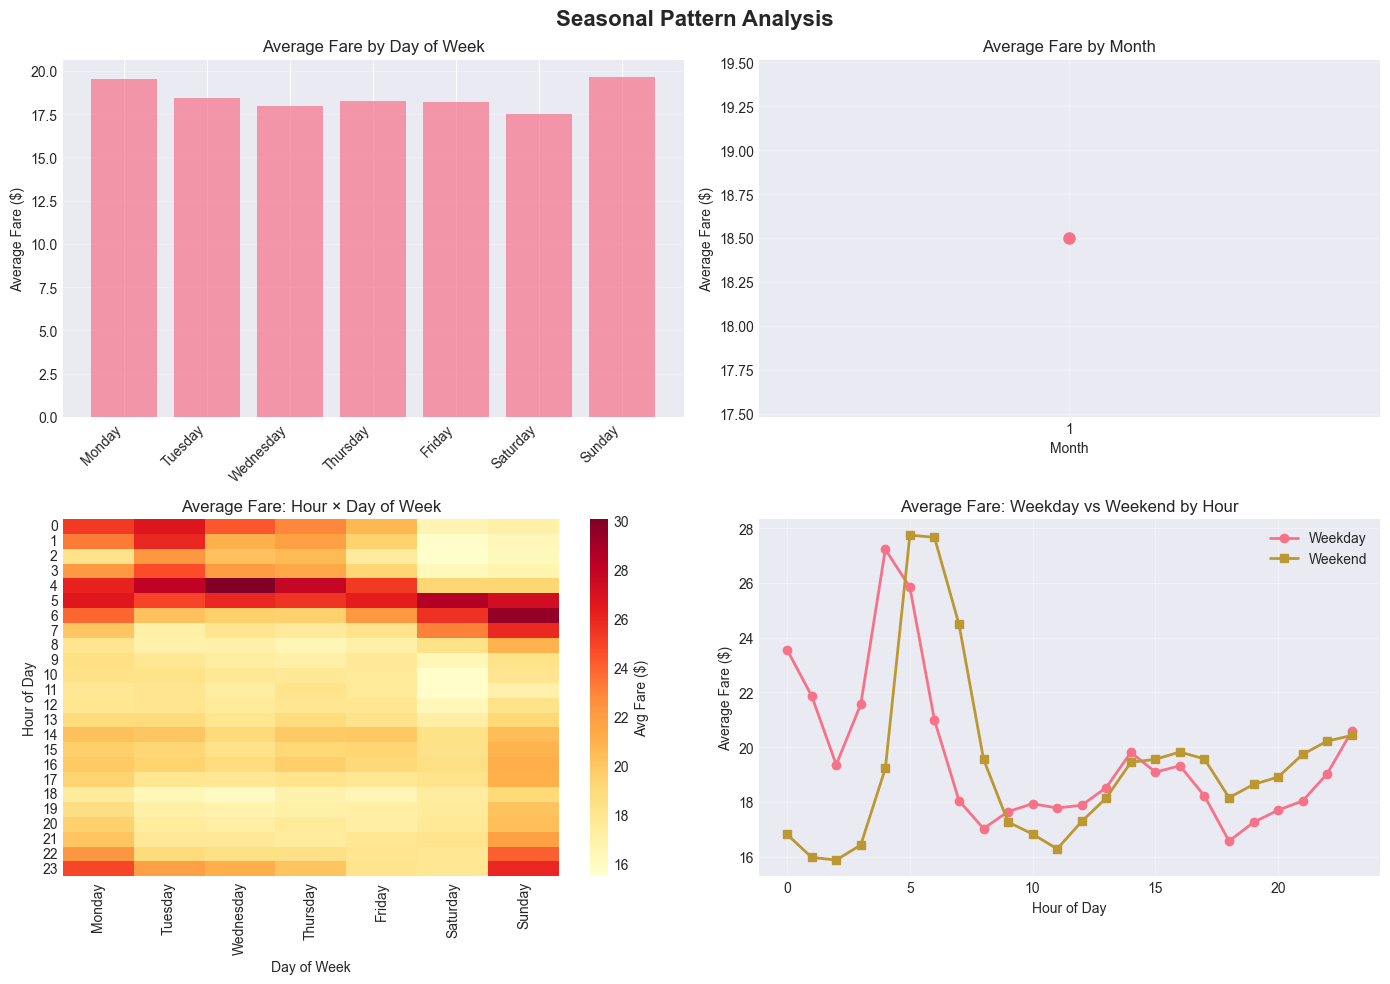

In [3]:
# Analyze patterns by day of week
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_ts['day_name'] = df_ts.index.day_name()

daily_by_dow = df_ts.groupby('day_name')['fare_amount'].agg(['mean', 'std', 'count']).reindex(day_order)

# Analyze patterns by month
monthly = df_ts.groupby('month')['fare_amount'].agg(['mean', 'std', 'count'])

# Visualize seasonal patterns
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Seasonal Pattern Analysis', fontsize=16, fontweight='bold')

# Average fare by day of week
axes[0, 0].bar(range(len(daily_by_dow)), daily_by_dow['mean'], alpha=0.7)
axes[0, 0].set_xticks(range(len(daily_by_dow)))
axes[0, 0].set_xticklabels(daily_by_dow.index, rotation=45, ha='right')
axes[0, 0].set_title('Average Fare by Day of Week')
axes[0, 0].set_ylabel('Average Fare ($)')
axes[0, 0].grid(True, alpha=0.3, axis='y')

# Average fare by month
axes[0, 1].plot(monthly.index, monthly['mean'], marker='o', linewidth=2, markersize=8)
axes[0, 1].set_title('Average Fare by Month')
axes[0, 1].set_xlabel('Month')
axes[0, 1].set_ylabel('Average Fare ($)')
axes[0, 1].set_xticks(monthly.index)
axes[0, 1].grid(True, alpha=0.3)

# Hourly pattern (heatmap by day of week)
# What is .unstack()? It converts a multi-index Series into a DataFrame by moving
# one index level to columns. Here, 'day_name' becomes column headers, making it
# easy to create a heatmap where rows=hours, columns=days.
hourly_dow = df_ts.groupby(['day_name', 'hour'])['fare_amount'].mean().unstack(level=0).reindex(columns=day_order)
sns.heatmap(hourly_dow, annot=False, cmap='YlOrRd', ax=axes[1, 0], cbar_kws={'label': 'Avg Fare ($)'})
axes[1, 0].set_title('Average Fare: Hour × Day of Week')
axes[1, 0].set_xlabel('Day of Week')
axes[1, 0].set_ylabel('Hour of Day')

# Weekend vs weekday comparison
df_ts['is_weekend'] = df_ts['day_of_week'].isin([5, 6])
weekend_comparison = df_ts.groupby(['is_weekend', 'hour'])['fare_amount'].mean().unstack(level=0)
axes[1, 1].plot(weekend_comparison.index, weekend_comparison[False], label='Weekday', marker='o', linewidth=2)
axes[1, 1].plot(weekend_comparison.index, weekend_comparison[True], label='Weekend', marker='s', linewidth=2)
axes[1, 1].set_title('Average Fare: Weekday vs Weekend by Hour')
axes[1, 1].set_xlabel('Hour of Day')
axes[1, 1].set_ylabel('Average Fare ($)')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Step 4: Correlation Analysis

**What is correlation?** Correlation measures how two variables move together:

- **+1.0:** Perfect positive relationship (when one goes up, the other always goes up)
- **0.0:** No relationship (variables are independent)
- **-1.0:** Perfect negative relationship (when one goes up, the other always goes down)

**Important caveat:** Correlation ≠ Causation. Just because fare_amount and trip_distance are correlated doesn't mean distance causes fare - there could be other factors (tolls, time of day, etc.).

**Why this matters for modeling:** Highly correlated features (|r| > 0.9) are redundant - we might only need one. Moderate correlations (0.3-0.7) suggest useful relationships we can exploit.

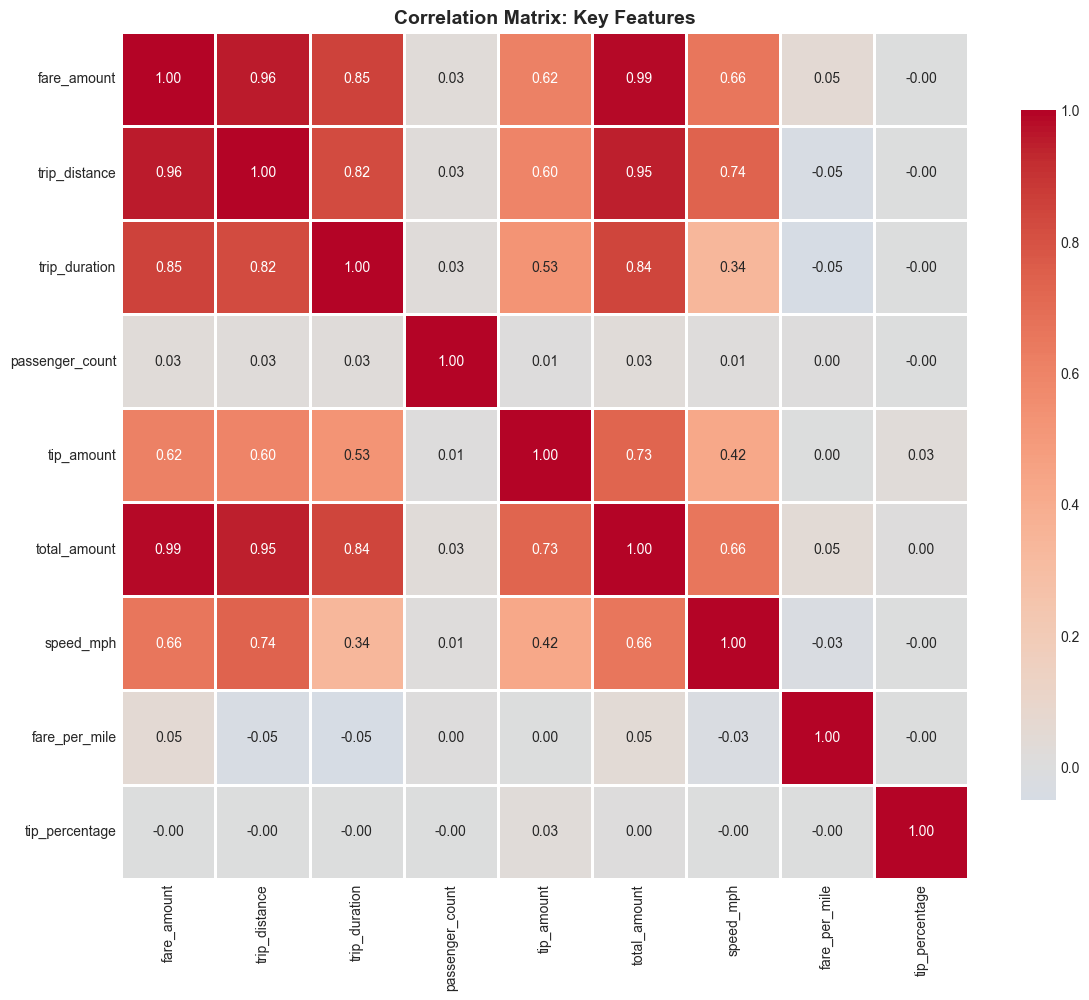

### 🔗 Strongest Correlations (|r| > 0.5)

- **fare_amount** ↔ **total_amount**: `0.988`
- **fare_amount** ↔ **trip_distance**: `0.958`
- **trip_distance** ↔ **total_amount**: `0.949`
- **fare_amount** ↔ **trip_duration**: `0.854`
- **trip_duration** ↔ **total_amount**: `0.844`
- **trip_distance** ↔ **trip_duration**: `0.820`
- **trip_distance** ↔ **speed_mph**: `0.739`
- **tip_amount** ↔ **total_amount**: `0.730`
- **fare_amount** ↔ **speed_mph**: `0.660`
- **total_amount** ↔ **speed_mph**: `0.656`
- **fare_amount** ↔ **tip_amount**: `0.616`
- **trip_distance** ↔ **tip_amount**: `0.601`
- **trip_duration** ↔ **tip_amount**: `0.529`

In [4]:
# Select numeric features for correlation
numeric_features = ['fare_amount', 'trip_distance', 'trip_duration', 'passenger_count', 
                    'tip_amount', 'total_amount', 'speed_mph', 'fare_per_mile', 'tip_percentage']

corr_matrix = df_ts[numeric_features].corr()

# Visualize correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix: Key Features', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Identify strongest correlations
display(Markdown("### 🔗 Strongest Correlations (|r| > 0.5)"))

corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        corr_val = corr_matrix.iloc[i, j]
        if abs(corr_val) > 0.5:
            corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_val))

corr_list = "\n".join([f"- **{feat1}** ↔ **{feat2}**: `{corr:.3f}`"
                       for feat1, feat2, corr in sorted(corr_pairs, key=lambda x: abs(x[2]), reverse=True)])
display(Markdown(corr_list))

### Step 5: Multi-Dimensional Analysis

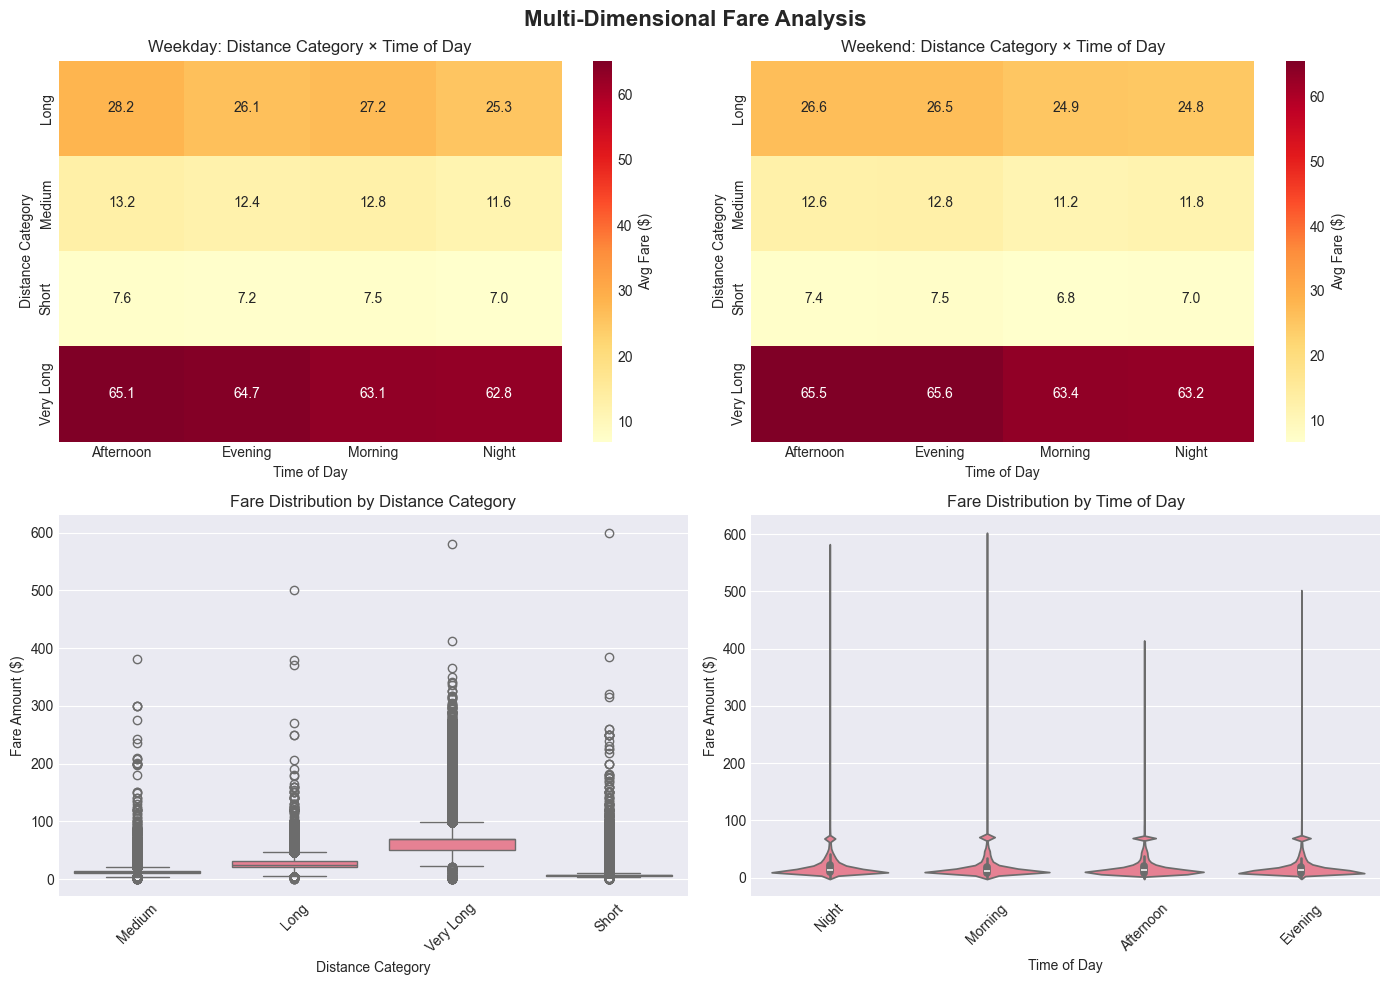

In [5]:
# Analyze fare by multiple dimensions: distance category, time of day, day type
multi_dim = df_ts.groupby(['distance_category', 'time_of_day', 'is_weekend'])['fare_amount'].mean().unstack(level=2)

# Note: unstack converts boolean to int (False=0, True=1)
# Visualize
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Multi-Dimensional Fare Analysis', fontsize=16, fontweight='bold')

# Distance category vs time of day (weekday, is_weekend=0)
# Need to unstack the Series to create a 2D DataFrame for heatmap
weekday_col = 0 if 0 in multi_dim.columns else multi_dim.columns[0]
weekday_data = multi_dim[weekday_col].unstack(level=1)  # Unstack time_of_day to columns
sns.heatmap(weekday_data, annot=True, fmt='.1f', cmap='YlOrRd', ax=axes[0, 0], cbar_kws={'label': 'Avg Fare ($)'})
axes[0, 0].set_title('Weekday: Distance Category × Time of Day')
axes[0, 0].set_xlabel('Time of Day')
axes[0, 0].set_ylabel('Distance Category')

# Distance category vs time of day (weekend, is_weekend=1)
weekend_col = 1 if 1 in multi_dim.columns else multi_dim.columns[-1]
weekend_data = multi_dim[weekend_col].unstack(level=1)  # Unstack time_of_day to columns
sns.heatmap(weekend_data, annot=True, fmt='.1f', cmap='YlOrRd', ax=axes[0, 1], cbar_kws={'label': 'Avg Fare ($)'})
axes[0, 1].set_title('Weekend: Distance Category × Time of Day')
axes[0, 1].set_xlabel('Time of Day')
axes[0, 1].set_ylabel('Distance Category')

# Box plot: Fare by distance category
sns.boxplot(data=df_ts, x='distance_category', y='fare_amount', ax=axes[1, 0])
axes[1, 0].set_title('Fare Distribution by Distance Category')
axes[1, 0].set_xlabel('Distance Category')
axes[1, 0].set_ylabel('Fare Amount ($)')
axes[1, 0].tick_params(axis='x', rotation=45)

# Violin plot: Fare by time of day
sns.violinplot(data=df_ts, x='time_of_day', y='fare_amount', ax=axes[1, 1])
axes[1, 1].set_title('Fare Distribution by Time of Day')
axes[1, 1].set_xlabel('Time of Day')
axes[1, 1].set_ylabel('Fare Amount ($)')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

---

## Phase 7: Modeling Preparation

**What we're about to do:** We'll prepare our data for modeling by splitting it properly and selecting features. This is critical - mistakes here can invalidate your entire analysis.

**Why temporal split matters:**

If we randomly split time series data, we might train on future data and test on past data. This creates **data leakage** - the model "sees the future" during training, which inflates performance metrics.

**Example of the problem:**

- Random split: Train on Jan 15, Feb 3, Mar 10... Test on Jan 2, Feb 20, Mar 5...
- The model learns patterns from February and March, then tests on January
- This is unrealistic - in real life, we predict the future using only past data

**Temporal split fixes this:**

- Train on Jan 1-24, test on Jan 25-31
- Model only uses past data to predict future
- Performance metrics reflect real-world accuracy

### Learning Objectives

- Split data temporally for time series
- Select and prepare features
- Handle categorical variables
- Create final modeling dataset

### Step 1: Temporal Train/Test Split

### ✂️ Temporal Train/Test Split

,Dataset,Trips,Date Range
0,Train,"2,303,268",2023-01-01 00:00:05 to 2023-01-25 23:08:48
1,Test,"575,817",2023-01-25 23:08:49 to 2023-01-31 23:59:59


**Split date:** 2023-01-25 23:08:48.200000

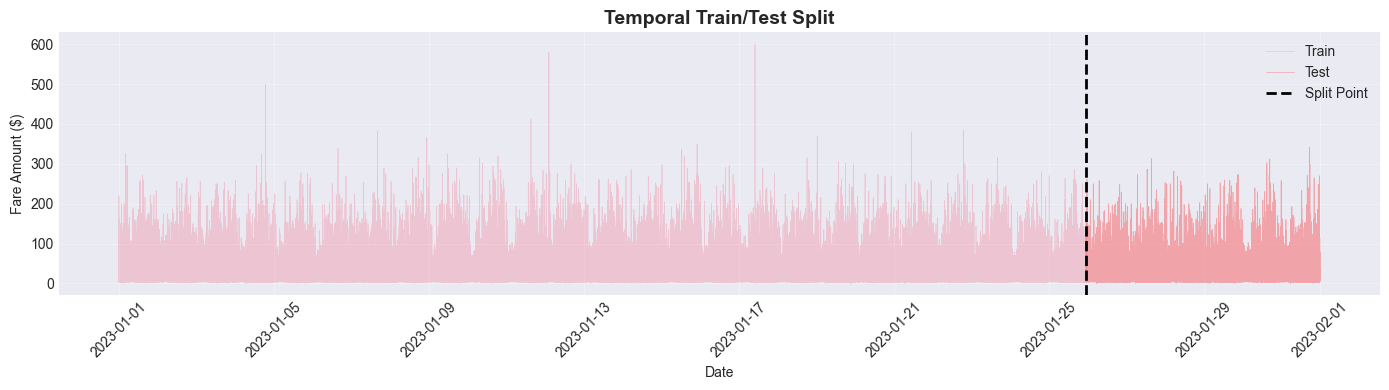

In [6]:
# For data with temporal structure, we must split by time (not randomly)
# Train on earlier data, test on later data

# Sort by datetime to ensure temporal order
df_model = df_ts.reset_index().sort_values('pickup_datetime').copy()

# Train/test split configuration
TRAIN_RATIO = 0.80  # 80% for training, 20% for testing

# Define temporal split point
# IMPORTANT: For time series, we split by time (not randomly) to prevent data leakage
split_date = df_model['pickup_datetime'].quantile(TRAIN_RATIO)

# Create train/test split
train = df_model[df_model['pickup_datetime'] < split_date].copy()
test = df_model[df_model['pickup_datetime'] >= split_date].copy()

display(Markdown("### ✂️ Temporal Train/Test Split"))
display(pd.DataFrame({
    'Dataset': ['Train', 'Test'],
    'Trips': [f"{len(train):,}", f"{len(test):,}"],
    'Date Range': [
        f"{train['pickup_datetime'].min()} to {train['pickup_datetime'].max()}",
        f"{test['pickup_datetime'].min()} to {test['pickup_datetime'].max()}"
    ]
}))
display(Markdown(f"**Split date:** {split_date}"))

# Visualize the split
plt.figure(figsize=(14, 4))
plt.plot(train['pickup_datetime'], train['fare_amount'], alpha=0.3, label='Train', linewidth=0.5)
plt.plot(test['pickup_datetime'], test['fare_amount'], alpha=0.3, label='Test', linewidth=0.5, color='red')
plt.axvline(split_date, color='black', linestyle='--', linewidth=2, label='Split Point')
plt.title('Temporal Train/Test Split', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Fare Amount ($)')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Step 2: Feature Selection

**What we're about to do:** We'll select which features (variables) to use for modeling. Not all features are useful - some are redundant, some are irrelevant, and some might cause problems.

**Why feature selection matters:**

- Too many features can cause overfitting
- Some features might be highly correlated (redundant)
- Simpler models are easier to interpret and often generalize better
- Feature selection is iterative - we'll refine our choices

**🔬 Try This First: Explore Feature Relationships**

Before selecting features, let's understand what we have:

In [7]:
# Quick exploration: Which features are correlated?
# This helps us identify redundant features

# First, define our target and potential features
target = 'fare_amount'

# List all numeric features we might use
numeric_features = ['hour', 'day_of_week', 'month', 'is_weekend',
                   'trip_distance', 'passenger_count', 'trip_duration',
                   'speed_mph', 'fare_per_mile']

# Check which features are actually available in the data
available_numeric = [f for f in numeric_features if f in df_model.columns]

# Calculate correlation with target
if available_numeric:
    correlation_with_target = df_model[available_numeric + [target]].corr()[target].sort_values(ascending=False)
    print("Features correlated with fare_amount:")
    print(correlation_with_target)
    print()

    # Question: Which features are most correlated with the target?
    # Which features are highly correlated with each other (redundant)?

Features correlated with fare_amount:
fare_amount        1.000000
trip_distance      0.958400
trip_duration      0.853857
speed_mph          0.660168
fare_per_mile      0.054041
passenger_count    0.029984
is_weekend         0.002646
hour               0.001977
day_of_week       -0.004786
month                   NaN
Name: fare_amount, dtype: float64



**Learning goal:** Understanding feature relationships helps you make informed selection decisions. Features with high correlation to the target are likely useful. Features highly correlated with each other (|r| > 0.9) might be redundant.

Now let's select our features:

> **⚠️ Note on `fare_per_mile`:** This feature is derived from `fare_amount` (our target), so including it could cause **feature leakage**. In practice, remove features derived from your target variable.

In [8]:
# Define target variable
target = 'fare_amount'

# Select features for modeling
# Include temporal, geographic, and trip characteristics
feature_cols = [
    # Temporal features
    'hour', 'day_of_week', 'month', 'is_weekend',
    # Trip characteristics
    'trip_distance', 'passenger_count', 'trip_duration',
    # Derived features
    'speed_mph',
    'fare_per_mile',  # Derived from target - should we include this?
    # Categorical (will need encoding)
    'time_of_day', 'distance_category', 'pickup_borough'
]

# Check feature availability
available_features = [f for f in feature_cols if f in df_model.columns]
missing_features = [f for f in feature_cols if f not in df_model.columns]

display(Markdown("### 📋 Feature Availability"))
display(Markdown(f"**Available features:** `{available_features}`"))
if missing_features:
    display(Markdown(f"⚠️ **Missing features** (will skip): `{missing_features}`"))

# Select available features
X_train = train[available_features].copy()
X_test = test[available_features].copy()
y_train = train[target].copy()
y_test = test[target].copy()

display(pd.DataFrame({
    'Dataset': ['X_train', 'X_test'],
    'Shape': [
        f"{X_train.shape[0]:,} × {X_train.shape[1]}",
        f"{X_test.shape[0]:,} × {X_test.shape[1]}"
    ]
}))

### 📋 Feature Availability

**Available features:** `['hour', 'day_of_week', 'month', 'is_weekend', 'trip_distance', 'passenger_count', 'trip_duration', 'speed_mph', 'fare_per_mile', 'time_of_day', 'distance_category', 'pickup_borough']`

,Dataset,Shape
0,X_train,"2,303,268 × 12"
1,X_test,"575,817 × 12"


### Step 3: Handle Categorical Variables

In [9]:
# Identify categorical variables
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()

display(Markdown("### 🏷️ Feature Types"))
display(Markdown(f"**Categorical features:** `{categorical_cols}`"))
display(Markdown(f"**Numeric features:** `{numeric_cols}`"))

# For simplicity, we'll use pandas get_dummies for one-hot encoding
# In practice, you might use sklearn's OneHotEncoder

X_train_encoded = pd.get_dummies(X_train, columns=categorical_cols, prefix=categorical_cols, drop_first=True)
X_test_encoded = pd.get_dummies(X_test, columns=categorical_cols, prefix=categorical_cols, drop_first=True)

# Ensure test set has same columns as training set
# Add missing columns (with 0s) and remove extra columns
for col in X_train_encoded.columns:
    if col not in X_test_encoded.columns:
        X_test_encoded[col] = 0

X_test_encoded = X_test_encoded[X_train_encoded.columns]

display(Markdown("### ✅ After One-Hot Encoding"))
display(pd.DataFrame({
    'Dataset': ['Training features', 'Test features'],
    'Shape': [
        f"{X_train_encoded.shape[0]:,} × {X_train_encoded.shape[1]}",
        f"{X_test_encoded.shape[0]:,} × {X_test_encoded.shape[1]}"
    ]
}))
display(Markdown(f"**Feature names:** `{list(X_train_encoded.columns)[:10]}...` ({len(X_train_encoded.columns)} total)"))

### 🏷️ Feature Types

**Categorical features:** `['time_of_day', 'distance_category', 'pickup_borough']`

**Numeric features:** `['hour', 'day_of_week', 'month', 'trip_distance', 'passenger_count', 'trip_duration', 'speed_mph', 'fare_per_mile']`

### ✅ After One-Hot Encoding

,Dataset,Shape
0,Training features,"2,303,268 × 21"
1,Test features,"575,817 × 21"


**Feature names:** `['hour', 'day_of_week', 'month', 'is_weekend', 'trip_distance', 'passenger_count', 'trip_duration', 'speed_mph', 'fare_per_mile', 'time_of_day_Evening']...` (21 total)

### Step 4: Handle Missing Values in Features

In [10]:
# Check for missing values
display(Markdown("### 🔍 Missing Values in Training Set"))
missing_in_train = X_train_encoded.isnull().sum()[X_train_encoded.isnull().sum() > 0]
if len(missing_in_train) == 0:
    display(Markdown("✅ **No missing values!**"))
else:
    missing_df = pd.DataFrame({'Column': missing_in_train.index, 'Missing Count': missing_in_train.values})
    display(missing_df)

# Fill missing values (using training set statistics)
# For numeric columns, use median
for col in numeric_cols:
    if col in X_train_encoded.columns:
        median_val = X_train_encoded[col].median()
        X_train_encoded[col] = X_train_encoded[col].fillna(median_val)
        X_test_encoded[col] = X_test_encoded[col].fillna(median_val)

display(Markdown("### ✅ After Imputation"))
display(pd.DataFrame({
    'Dataset': ['Train', 'Test'],
    'Missing Values': [
        X_train_encoded.isnull().sum().sum(),
        X_test_encoded.isnull().sum().sum()
    ]
}))

### 🔍 Missing Values in Training Set

,Column,Missing Count
0,speed_mph,41


### ✅ After Imputation

,Dataset,Missing Values
0,Train,0
1,Test,0


### ⚠️ Common Pitfall: Random Split on Time Series Data

**The mistake:** Using `train_test_split()` with `shuffle=True` on time series data

```
# ❌ Wrong for time series
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(X, shuffle=True)  # DON'T DO THIS!

# ✅ Correct for time series
split_date = df['datetime'].quantile(0.8)
train = df[df['datetime'] < split_date]
test = df[df['datetime'] >= split_date]
```

### 🐛 Debugging Tips: Modeling Prep Issues

**Problem: Train and test sets have different column counts**

- Check for missing columns: `set(X_train.columns) - set(X_test.columns)`
- Align columns: `X_test = X_test.reindex(columns=X_train.columns, fill_value=0)`

**Problem: Categorical encoding creates different columns**

- Use same categories: Fit encoder on training, transform both
- Check for new categories: `set(X_test['col'].unique()) - set(X_train['col'].unique())`

### Step 5: Save Prepared Data

In [11]:
# Save prepared datasets for modeling
X_train_encoded.to_csv('../output/03_X_train.csv', index=False)
X_test_encoded.to_csv('../output/03_X_test.csv', index=False)
y_train.to_csv('../output/03_y_train.csv', index=False)
y_test.to_csv('../output/03_y_test.csv', index=False)

display(Markdown("### 💾 Prepared Datasets Saved"))
display(pd.DataFrame({
    'File': ['X_train', 'X_test', 'y_train', 'y_test'],
    'Shape': [
        f"{X_train_encoded.shape[0]:,} × {X_train_encoded.shape[1]}",
        f"{X_test_encoded.shape[0]:,} × {X_test_encoded.shape[1]}",
        f"{len(y_train):,}",
        f"{len(y_test):,}"
    ]
}))
display(Markdown("✅ **Ready for next phase: Modeling & Results!**"))

### 💾 Prepared Datasets Saved

,File,Shape
0,X_train,"2,303,268 × 21"
1,X_test,"575,817 × 21"
2,y_train,"2,303,268"
3,y_test,"575,817"


✅ **Ready for next phase: Modeling & Results!**

---

## Summary

**What we accomplished:**

1. ✅ **Analyzed trends over time** with moving averages
2. ✅ **Identified seasonal patterns** (day of week, month, hour)
3. ✅ **Performed correlation analysis** to understand relationships
4. ✅ **Created advanced visualizations** (heatmaps, multi-panel plots)
5. ✅ **Split data temporally** to prevent data leakage
6. ✅ **Selected and prepared features** for modeling
7. ✅ **Handled categorical variables** with encoding
8. ✅ **Prepared final datasets** for modeling

**Key Takeaways:**

- Temporal splits prevent data leakage when data has time structure
- Feature engineering creates predictive signals
- Categorical encoding is essential for ML models
- Advanced visualizations reveal hidden patterns
- Proper preparation ensures model quality

**Next:** Notebook 4 will build and evaluate predictive models.

---

![xkcd 1513](../media/xkcd_1513.png)

*Data preparation is where the real work happens.*